In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.feature_selection import VarianceThreshold

In [4]:
data_folder_path = Path('../../../data/')
print(os.listdir(data_folder_path))

['data_train_all_columns.csv', 'chordonomicon_raw.csv', 'final_test.csv', 'matrix_expanded_final_train.csv', 'density_expanded_final_train.csv', '.DS_Store', 'data_train_continuous_data.csv', 'spotify_final.csv', 'clean_test_with_4_grams.csv', 'final_train.csv', 'final_train_pop.csv', 'data_train_n_grams.csv', 'data_train_all.csv', 'clean_test_with_5_grams.csv', 'clean_test_with_3_grams.csv', 'final_test_pop.csv']


In [9]:
data = pd.read_csv(data_folder_path / 'data_train_all.csv')
data_columns = pd.read_csv(data_folder_path / 'data_train_all_columns.csv')
print("Training data shape:", data.shape)
print("Column table columns:", data_columns.columns)
print("Unique column types:", data_columns.column_type.unique())

predictor_ngrams_columns = data_columns[data_columns['column_type'] == 'predictor_n_grams']['column_name'].tolist()
print(f"Number of n-gram columns: {len(predictor_ngrams_columns)}")

# Extract n-gram features from data
predictors_ngrams = data[predictor_ngrams_columns]

target_columns = data_columns[data_columns['column_type'] == 'target']['column_name'].tolist()
print(f"Target columns: {target_columns}")
print(f"Number of target columns: {len(target_columns)}")

Training data shape: (255606, 142)
Column table columns: Index(['column_name', 'column_type'], dtype='object')
Unique column types: ['id' 'data' 'target' 'predictor_continuous' 'predictor_n_grams']
Number of n-gram columns: 109
Target columns: ['decade', 'main_genre', 'spotify_popularity']
Number of target columns: 3


In [10]:
def select_ngram_features_by_variance(predictors, threshold=0.01):
    """Select n-gram features above variance threshold.

    Note: For binary features, variance = p(1-p) where p is proportion of 1s.
    Maximum variance is 0.25 (when p=0.5).
    """
    variances = predictors.var()

    # Calculate proportion of 1s for context
    proportions = predictors.mean()

    print("Variance statistics:")
    print(f"Min: {variances.min():.6f}, Max: {variances.max():.6f}, Mean: {variances.mean():.6f}")
    print(f"\nTop 10 highest variance n-grams:")
    print(variances.sort_values(ascending=False).head(10))
    print(f"\nTop 10 lowest variance n-grams:")
    print(variances.sort_values().head(10))

    selector = VarianceThreshold(threshold=threshold)
    selected_features = selector.fit_transform(predictors)

    selected_names = predictors.columns[selector.get_support()].tolist()
    removed_names = predictors.columns[~selector.get_support()].tolist()

    print(f"\nSelected: {len(selected_names)}, Removed: {len(removed_names)}")
    print(f"Removal rate: {len(removed_names)/len(predictors.columns):.1%}")

    if len(removed_names) > 0 and len(removed_names) <= 20:
        print(f"Removed features: {removed_names}")

    return pd.DataFrame(selected_features, columns=selected_names, index=predictors.index), variances

def plot_ngram_variance_distribution(variances, threshold=0.01):
    """Plot variance distribution for n-gram features."""
    plt.figure(figsize=(15, 8))

    # Histogram
    plt.subplot(2, 1, 1)
    plt.hist(variances, bins=50, edgecolor='black')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold={threshold}')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.title('Distribution of N-gram Feature Variances')
    plt.legend()

    # Sorted bar chart (only show if manageable number of features)
    if len(variances) <= 200:
        plt.subplot(2, 1, 2)
        variances.sort_values().plot(kind='barh')
        plt.xlabel('Variance')
        plt.title('Variance of N-gram Features (Sorted)')
        plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold={threshold}')
        plt.legend()

    plt.tight_layout()
    plt.show()

Variance statistics:
Min: 0.028963, Max: 0.243751, Mean: 0.095197

Top 10 highest variance n-grams:
contains_G,C,G       0.243751
contains_C,G,C       0.236340
contains_C,G,D       0.228439
contains_C,D,G       0.210360
contains_D,G,C       0.203699
contains_D,C,G       0.197572
contains_G,D,C       0.186362
contains_C,G,C,G     0.186206
contains_C,G,Amin    0.184915
contains_G,C,D       0.179131
dtype: float64

Top 10 lowest variance n-grams:
contains_G,Emin,C,G,Emin       0.028963
contains_Amin,C,G,Amin,C       0.030223
contains_C,Amin,C,Amin,C       0.031538
contains_Emin,C,G,Emin,C       0.032160
contains_Amin,G,Amin,G,Amin    0.032481
contains_G,Amin,C,G,Amin       0.032649
contains_F,Amin,G,F,Amin       0.034592
contains_G,C,Amin,F,G          0.035031
contains_G,Amin,G,Amin,G       0.035347
contains_C,G,Emin,C,G          0.036212
dtype: float64

Selected: 89, Removed: 20
Removal rate: 18.3%
Removed features: ['contains_C,Amin,C,Amin', 'contains_Amin,C,G,Amin', 'contains_Emin,C,G,

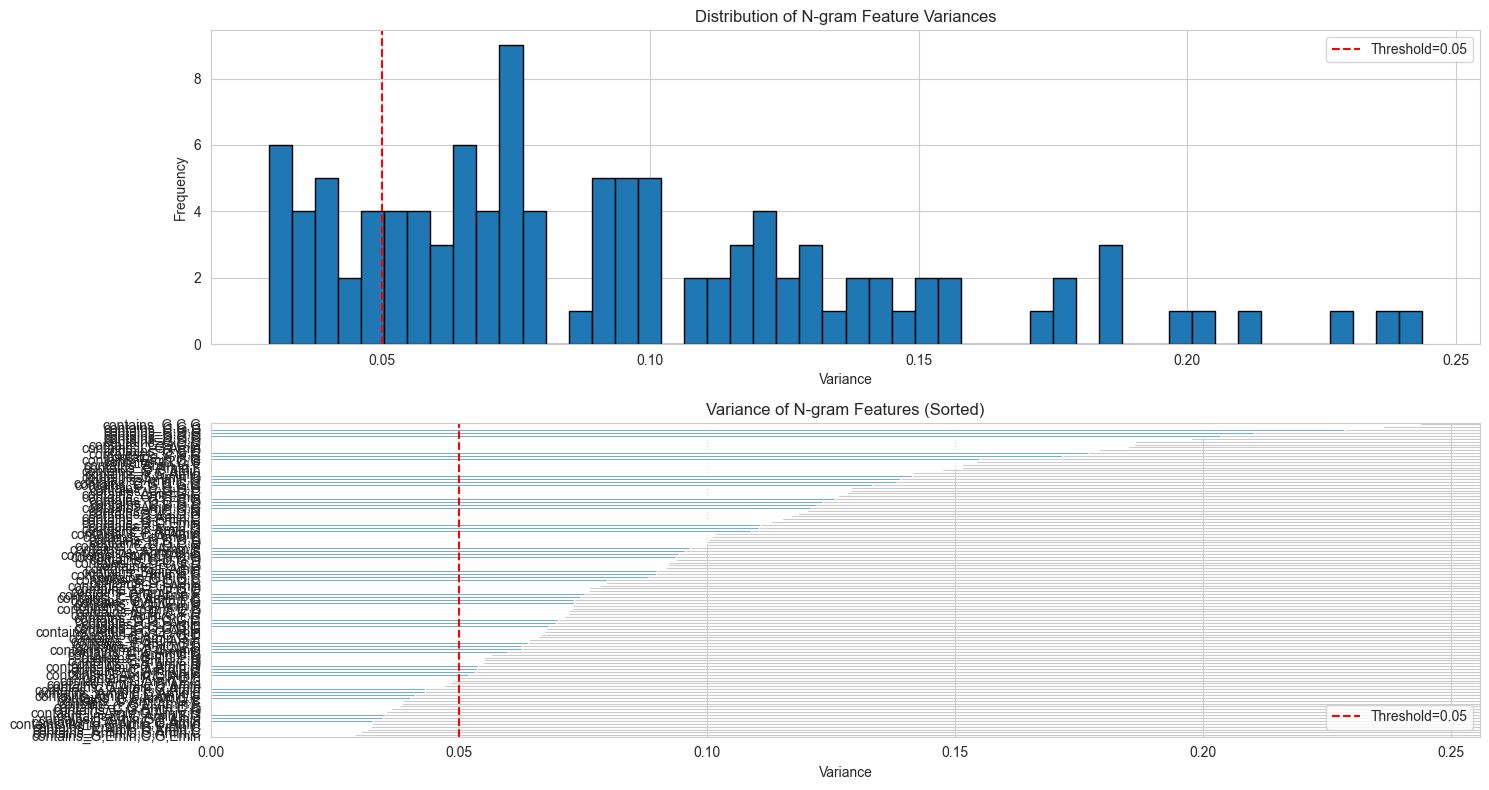

In [20]:
# Test with very low threshold (remove only extremely rare n-grams)
# threshold = 0.001 # This threshold does not remove any features
# threshold = 0.01 # This threshold does not remove any features
# threshold = 0.025 # This threshold does not remove any features
threshold = 0.05 # Selected: 89, Removed: 20 - Removal rate: 18.3%
# threshold = 0.075  # Selected: 60, Removed: 49 - Removal rate: 45.0%

predictors_ngrams_filtered, variances_ngrams = select_ngram_features_by_variance(
    predictors_ngrams, threshold=threshold
)
plot_ngram_variance_distribution(variances_ngrams, threshold=threshold)